In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행 시 변수 변경
BATCH_SIZE = 12
EPOCHS = 20

In [3]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# validation 데잍터가 16개 밖에 없기 때문에 tarin데이터에서 일부 가져온다.
# 데이터를 8:2로 나눠준다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(10)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


데이터 갯수 - train: 4185, test: 624, val: 1047

CNN 모델은 데이터가 클래스별 balance가 좋을수록 학습을 잘 한다.
정상/폐렴 데이터가 balance한지 확인이 필요하다.
데이터의 갯수를 구하는데, 경로를 확인해보면 정상인지 폐렴인지 알 수 있다.

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[3000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person351_bacteria_1617.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0630-0001.jpeg


정상: NORMAL. 폐렴: PNEUMONIA

In [6]:
# 갯수구하기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"training데이터의 Normal 수: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"training데이터의 Pneumonia 수: {COUNT_PNEUMONIA}")

training데이터의 Normal 수: 1089
training데이터의 Pneumonia 수: 3096


데이터가 클래스 불균형하다. Normal:Pneumonia = 1:3

In [7]:
# tf.data 인스턴스:: mini-batch로 작업
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

현재 이미지데이터만 있기 때문에 labeling작업이 필요하다.
그리고 GPU 를 효율적으로 사용하기 위해 이미지 통일된 사이즈로 변경해준다.

In [8]:
# 라벨 데이터 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴: 양성(True), 노멀: 음성(False)

In [9]:
# 이미지 알맞은 형식으로 변경 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

In [10]:
# 이미지와 라벨 처리 함수
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train, validation 데이터 셋 처리 (num_parallel_calls=AUTOTUNE은 빠른 처리 가능하도록 도와줌)
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 데이터 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


테스트 셋도 같은 처리를 해준다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

성능최적화를 위해 데이터셋을 효율적으로 셔플, 반복, 배치를 적용한 데이터 셋을 만들어 반환한다. 충분한 이미지 데이터를 위해 좌우 반전 데이터도 준비한다.

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정크기버퍼 유지, 무작위 섞음
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)# 미리 데이터셋 준비

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


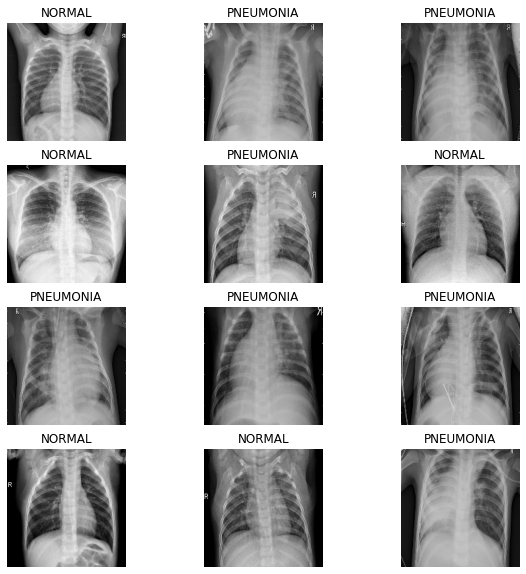

In [15]:
# 데이터 시각화
# 이미지 배치를 입력하면 여러장의 이미지를 보여줌
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
# CNN 모델링
# Convolution block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# Sequential Model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [17]:
# 데이터 imbalance 처리

# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

# Weight balancing 테크닉을 사용
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Training images count: 4185
Validating images count: 1047
Weight for NORMAL: 1.92
Weight for PNEUMONIA: 0.68


In [18]:
# Model Training

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [ # 성과에 대해서 측정
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # 데이터 라벨: 0,1같이 두 종류임
        metrics=METRICS 
    )

In [19]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
348/348 [==============================] - 80s 145ms/step - loss: 0.4237 - accuracy: 0.7773 - precision: 0.9383 - recall: 0.7481 - val_loss: 0.8341 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 2/20
348/348 [==============================] - 50s 142ms/step - loss: 0.2514 - accuracy: 0.8973 - precision: 0.9707 - recall: 0.8881 - val_loss: 0.7954 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 3/20
348/348 [==============================] - 50s 143ms/step - loss: 0.2479 - accuracy: 0.9064 - precision: 0.9697 - recall: 0.9015 - val_loss: 0.1252 - val_accuracy: 0.9540 - val_precision: 0.9478 - val_recall: 0.9936
Epoch 4/20
348/348 [==============================] - 50s 144ms/step - loss: 0.2271 - accuracy: 0.9107 - precision: 0.9725 - recall: 0.9049 - val_loss: 0.2499 - val_accuracy: 0.8879 - val_precision: 0.8711 - val_recall: 0.9987
Epoch 5/20
348/348 [==============================] - 51s 145ms/step - loss: 0.1977 - accura

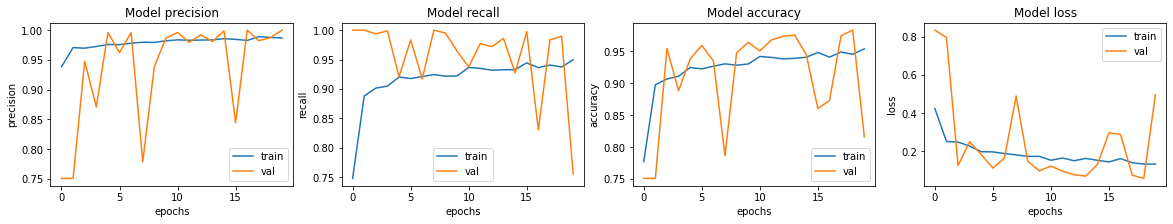

In [20]:
# 결과 확인과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [21]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

52/52 [==============================] - 5s 86ms/step - loss: 0.4718 - accuracy: 0.8718 - precision: 0.9016 - recall: 0.8923
Loss: 0.47177156805992126,
Accuracy: 0.8717948794364929,
Precision: 0.9015544056892395,
Recall: 0.892307698726654


데이터 추가, 배치 16->12, epoch 25->20 accuracy 약 3% 증가했다. 
의료분야인 만큼 정확한 더 좋은 데이터가 필요할것 같다.
모델 사용방식은 알겠지만 왜 저렇게 구현이 됐을까는 좀 더 공부가 필요하다.